## PDE 
The TTI wave equation for the square slowness m, thomsen parametersd $\epsilon$, $\delta$, $\theta$ and $\Phi$ (dip and asymuth)  and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 p(x,t)}{dt^2} - (1+2\epsilon)(G_{\bar{x}\bar{x}} + G_{\bar{y}\bar{y}}) p(x,t) - \sqrt{(1+2\delta)}G_{\bar{z}\bar{z}} r(x,t) =q  \\
 &m \frac{d^2 r(x,t)}{dt^2} -  \sqrt{(1+2\delta)}(G_{\bar{x}\bar{x}} + G_{\bar{y}\bar{y}}) p(x,t) - G_{\bar{z}\bar{z}} r(x,t) =q    \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}


where
\begin{cases} 
G_{\bar{x}\bar{x}} & = cos(\phi)^2 cos(\theta)^2 \frac{d^2}{dx^2} +sin(\phi)^2 cos(\theta)^2 \frac{d^2}{dy^2}+ sin(\theta)^2 \frac{d^2}{dz^2} + sin(2\phi) cos(\theta)^2 \frac{d^2}{dx dy} - sin(\phi) sin(2\theta) \frac{d^2}{dy dz} -cos(\phi) sin(2\theta) \frac{d^2}{dx dz} \\
G_{\bar{y}\bar{y}} & =  sin(\phi)^2 \frac{d^2}{dx^2} +cos(\phi)^2  \frac{d^2}{dy^2} - sin(2\phi)^2 \frac{d^2}{dx dy}\\
G_{\bar{z}\bar{z}} & = cos(\phi)^2 sin(\theta)^2 \frac{d^2}{dx^2} +sin(\phi)^2 sin(\theta)^2 \frac{d^2}{dy^2}+ cos(\theta)^2 \frac{d^2}{dz^2} + sin(2\phi) sin(\theta)^2 \frac{d^2}{dx dy} + sin(\phi) sin(2\theta) \frac{d^2}{dy dz} +cos(\phi) sin(2\theta) \frac{d^2}{dx dz} \\ 
\end{cases}
with the zero initial conditons to guaranty unicity of the solution

It correspondto a velocity model where the velocity in the z direction is different from the velocity in the xy plane

In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
from functools import reduce
from operator import mul
init_printing()

In [2]:
p=Function('p')
r=Function('r')

s,h,x,y,z = symbols('s h x y z')
m=M(x,y,z)
q=Q(x,y,z,t)
d=D(x,y,z,t)
e=E(x,y,z)

A=epsilon(x,y,z)  # (1 + 2epsilon) but make the symbolic simpler
B=delta(x,y,z) # sqrt(1 + 2epsilon) but make the symbolic simpler
Th=theta(x,y,z)
Ph=phi(x,y,z)


In [3]:
order=1

indxx = [(x + i * h) for i in range(-order, order + 1)]
indyy = [(y + i * h) for i in range(-order, order + 1)]
indzz = [(z + i * h) for i in range(-order, order + 1)]

In [4]:
dttp=as_finite_diff(p(x,y,z,t).diff(t,t), [t-s,t, t+s])
dttr=as_finite_diff(r(x,y,z,t).diff(t,t), [t-s,t, t+s])
dtp=as_finite_diff(p(x,y,z,t).diff(t), [t-s,t])
dtr=as_finite_diff(r(x,y,z,t).diff(t), [t-s,t])
# Spacial finite differences can easily be extended to higher order by increasing the list of sampling point in the next expression. 
# Be sure to keep this stencil symmetric and everything else in the notebook will follow.
dxxp=as_finite_diff(p(x,y,z,t).diff(x,x), indxx) 
dyyp=as_finite_diff(p(x,y,z,t).diff(y,y), indyy) 
dzzp=as_finite_diff(p(x,y,z,t).diff(z,z), indzz)
dxxr=as_finite_diff(r(x,y,z,t).diff(x,x), indxx) 
dyyr=as_finite_diff(r(x,y,z,t).diff(y,y), indyy) 
dzzr=as_finite_diff(r(x,y,z,t).diff(z,z), indzz)


# My 4th order stencil for cross derivatives
dxzp = .5/(h**2)*(-2*p(x,y,z,t) + p(x,y,z+h,t) + p(x,y,z-h,t) - p(x+h,y,z-h,t) + p(x-h,y,z,t) - p(x-h,y,z+h,t) + p(x+h,y,z,t))
dxzr = .5/(h**2)*(-2*r(x,y,z,t) + r(x,y,z+h,t) + r(x,y,z-h,t) - r(x+h,y,z-h,t) + r(x-h,y,z,t) - r(x-h,y,z+h,t) + r(x+h,y,z,t))

dxyp = .5/(h**2)*(-2*p(x,y,z,t) + p(x,y+h,z,t) + p(x,y-h,z,t) - p(x+h,y-h,z,t) + p(x-h,y,z,t) - p(x-h,y+h,z,t) + p(x+h,y,z,t))
dxyr = .5/(h**2)*(-2*r(x,y,z,t) + r(x,y+h,z,t) + r(x,y-h,z,t) - r(x+h,y-h,z,t) + r(x-h,y,z,t) - r(x-h,y+h,z,t) + r(x+h,y,z,t))

dyzp = .5/(h**2)*(-2*p(x,y,z,t) + p(x,y,z+h,t) + p(x,y,z-h,t) - p(x,y+h,z-h,t) + p(x,y-h,z,t) - p(x,y-h,z+h,t) + p(x,y+h,z,t))
dyzr = .5/(h**2)*(-2*r(x,y,z,t) + r(x,y,z+h,t) + r(x,y,z-h,t) - r(x,y+h,z-h,t) + r(x,y-h,z,t) - r(x,y-h,z+h,t) + r(x,y+h,z,t))

In [7]:
# add the *arg input and done
def cross_deriv(*args, **kwargs):
    deriv=0
    order = kwargs.get('order', 1)
    dims = kwargs.get('dims', (x, y))
    diff = kwargs.get('diff', h)
    assert(isinstance(dims, tuple) and len(dims) == 2)
    ind1r = [(dims[0] + i * diff) for i in range(-int((order) / 2) + 1 - (order<4), int((order + 1) / 2) + 2 - (order<4))]
    ind2r = [(dims[1] + i * diff) for i in range(-int((order) / 2) + 1 - (order<4), int((order + 1) / 2) + 2 - (order<4))]
    ind1l = [(dims[0] - i * diff) for i in range(-int((order) / 2) + 1 - (order<4), int((order + 1) / 2) + 2 - (order<4))]
    ind2l = [(dims[1] - i * diff) for i in range(-int((order) / 2) + 1 - (order<4), int((order + 1) / 2) + 2 - (order<4))]
    cx = finite_diff_weights(1, ind1r, dims[0])
    cx = cx[-1][-1]
    cy = finite_diff_weights(1, ind2r, dims[1])
    cy = cy[-1][-1]
    for i in range(0,len(ind1r)):
        for j in range(0,len(ind2r)):
            var1 = [a.subs({dims[0]: ind1r[i], dims[1]: ind2r[j]}) for a in args]
            var2 = [a.subs({dims[0]: ind1l[i], dims[1]: ind2l[j]}) for a in args]
            deriv += .25 * cy[j] * cx[i] * reduce(mul, var1, 1) + .25 * cy[len(ind2l)-j-1] * cx[len(ind1l)-i-1] * reduce(mul, var2, 1)
    return deriv

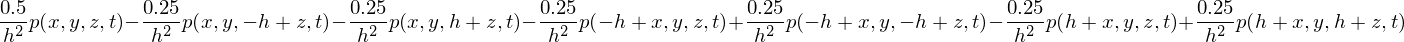

In [8]:
cross_deriv(p(x, y, z, t), order=1, dims=(x,z))

In [ ]:
Gxxp = c**2 * a**2 * dxxp + d**2 * a**2 * dyyp + b**2 * dzzp + 2 * d * c * a**2 * dxyp - d * 2 * b * a * dyzp - c * 2 * b * a * dxzp
Gyyp = b**2 * dxxp + c**2 * dyyp - (2 * d * c)**2 * dxyp
Gzzr = c**2 * b**2 * dxxr + d**2 * b**2 * dyyr + a**2 * dzzr + 2 * d * c * b**2 * dxyr + d * 2 * b * a * dyzr + c * 2 * b * a * dxzr

In [ ]:
def Bhaskarasin(angle):
    return 16 * angle * (3.14 - abs(angle))/(49.34 - 4 * abs(angle) * (3.14 - abs(angle)))

def Bhaskaracos(angle):
    return Bhaskarasin(angle + 1.57)

a = Bhaskaracos(Th)
b = Bhaskarasin(Th)
c = Bhaskaracos(Ph)
d = Bhaskaracos(Ph)

In [ ]:
print(a)
print(b)
print(c)
print(d)

In [ ]:
stencilp = s**2/m*( (2 - e/s) * p(x, y, z, t) - (m/s**2 + e/s)*p(x, y, z, t-s) + A * (Gxxp + Gyyp) + B * Gzzr)

In [ ]:
#stencilp = simplify(expand(stencilp))

In [ ]:
#cse((stencilp))

In [ ]:
stencilr = s**2/m*( (2 - e/s) * r(x, y, z, t) - (m/s**2 + e/s)*r(x, y, z, t+s) + A * (Gxxp + Gyyp) +  Gzzr)

In [ ]:
#stencilr=factor(simplify(expand(stencilr)))

In [ ]:
cse((stencilp,stencilr))

In [ ]:
#stencilr